In [1]:
import sys
# sys.path.insert(0, '../GET')


from Models.FCWithEvidences import graph_based_semantic_structure
from Fitting.FittingFC import char_man_fitter_query_repr1
import time
import json
from interactions import ClassificationInteractions
import matchzoo as mz
from handlers import cls_load_data
import argparse
import random
import numpy as np
import torch
import torch_utils
import numpy as np
import os
import datetime
from handlers.output_handler_FC import FileHandlerFC
from Evaluation import mzEvaluator as evaluator
from setting_keywords import KeyWordSettings
from matchzoo.embedding import entity_embedding
from Models.BiDAF.wrapper import GGNN, GGNN_with_GSL, Linear
from thirdparty.two_branches_attention import *


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset="Snopes"
fixed_length_left=30
fixed_length_right=100
log="logs/get"
loss_type="cross_entropy"
batch_size=32
num_folds=5
use_claim_source=0
use_article_source=1
path="formatted_data/declare/"
hidden_size=300
epochs=100
num_att_heads_for_words=5
num_att_heads_for_evds=2
gnn_window_size=3
lr=0.0001
gnn_dropout=0.2
seed=123756
gsl_rate=0.6
fixed_length_left_src_chars = 20
fixed_length_right_src_chars = 20
seed = 123756
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


In [2]:
dataset="PolitiFact"
fixed_length_left=30
fixed_length_right=100
log="logs/get"
loss_type="cross_entropy"
batch_size=32
num_folds=5
use_claim_source=1
use_article_source=1
path="formatted_data/declare/"
hidden_size=300
epochs=100
num_att_heads_for_words=3
num_att_heads_for_evds=1
gnn_window_size=3
lr=0.0001
gnn_dropout=0.2
seed=123456
gsl_rate=0.6
fixed_length_left_src_chars = 20
fixed_length_right_src_chars = 20
seed = 123456
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


In [3]:
preprocessor = mz.preprocessors.CharManPreprocessor(fixed_length_left = fixed_length_left,
                                                    fixed_length_right = fixed_length_right,
                                                    fixed_length_left_src = fixed_length_left_src_chars,
                                                    fixed_length_right_src = fixed_length_right_src_chars)

In [4]:
def get_graph(dataset="Snopes",fixed_length_left=30,fixed_length_right=100,log="logs/get",batch_size=32,gnn_window_size=3,fold_idx=4):
  if not os.path.exists(log):
        os.mkdir(log)
  secondary_log_folder = os.path.join(log, "log_results_%s" % (dataset))
  if not os.path.exists(secondary_log_folder):
    os.mkdir(secondary_log_folder)
  secondary_log_folder = secondary_log_folder
  root = os.path.join(os.path.join(path,dataset), "mapped_data")
  tx = time.time()
  kfold_dev_results, kfold_test_results = [], []
  list_metrics = KeyWordSettings.CLS_METRICS
  outfolder_per_fold = os.path.join(secondary_log_folder, "Fold_%s" % fold_idx)
  if not os.path.exists(outfolder_per_fold):
      os.mkdir(outfolder_per_fold)
  logfolder_result_per_fold = os.path.join(outfolder_per_fold, "result_%s.txt" % int(seed))
  file_handler = FileHandlerFC()
  file_handler.init_log_files(logfolder_result_per_fold)
  # root ="/content/drive/MyDrive/GET/formatted_data/declare/Snopes/mapped_data"
  # ------------------------------------------------------------------------------------
  predict_pack = cls_load_data.load_data(root + "/%sfold" % num_folds, 'test_%s' % '4', kfolds = num_folds)
  train_pack = cls_load_data.load_data(root + "/%sfold" % num_folds, 'train_%sres' % '4', kfolds = num_folds)
  valid_pack = cls_load_data.load_data(root, 'dev', kfolds = num_folds)

  a = train_pack.left["text_left"].str.lower().str.split().apply(len).max()
  b = valid_pack.left["text_left"].str.lower().str.split().apply(len).max()
  c = predict_pack.left["text_left"].str.lower().str.split().apply(len).max()
  max_query_length = max([a, b, c])
  min_query_length = min([a, b, c])

  a = train_pack.right["text_right"].str.lower().str.split().apply(len).max()
  b = valid_pack.right["text_right"].str.lower().str.split().apply(len).max()
  c = predict_pack.right["text_right"].str.lower().str.split().apply(len).max()
  max_doc_length = max([a, b, c])
  min_doc_length = min([a, b, c])

  file_handler.myprint("Min query length, " + str(min_query_length) + " Min doc length " + str(min_doc_length))
  file_handler.myprint("Max query length, " + str(max_query_length) + " Max doc length " + str(max_doc_length))
  global additional_data
  additional_data = {KeyWordSettings.OutputHandlerFactChecking: file_handler,
                      KeyWordSettings.GNN_Window: gnn_window_size}

  print('parsing data')

  train_processed = preprocessor.fit_transform(train_pack)  # This is a DataPack
  valid_processed = preprocessor.transform(valid_pack)
  predict_processed = preprocessor.transform(predict_pack)


  train_interactions = ClassificationInteractions(train_processed, **additional_data)
  valid_interactions = ClassificationInteractions(valid_processed, **additional_data)
  predict_interactions = ClassificationInteractions(predict_processed, **additional_data)
  file_handler.myprint('done extracting')
  return train_processed, valid_processed, predict_processed, train_interactions, valid_interactions, predict_interactions

In [5]:
train_processed, valid_processed, predict_processed, train_interactions, valid_interactions, predict_interactions = get_graph()

100%|██████████| 2756/2756 [00:00<00:00, 778942.17it/s]


Min query length, 21 Min doc length 100
Max query length, 28 Max doc length 100
parsing data


Processing text_left with chain_transform of Tokenize => Lowercase => PuncRemoval: 100%|██████████| 3127/3127 [00:00<00:00, 11523.95it/s]
Processing text_right with chain_transform of Tokenize => Lowercase => PuncRemoval: 100%|██████████| 21157/21157 [00:07<00:00, 2864.45it/s]
Processing text_right with extend: 100%|██████████| 21157/21157 [00:00<00:00, 143391.82it/s]
Processing text_left with chain_transform of Tokenize => Lowercase => PuncRemoval: 100%|██████████| 3127/3127 [00:00<00:00, 9095.53it/s]
Processing text_right with chain_transform of Tokenize => Lowercase => PuncRemoval: 100%|██████████| 21157/21157 [00:07<00:00, 2930.24it/s]
Processing text_right with transform: 100%|██████████| 2756/2756 [00:00<00:00, 187660.34it/s]
Processing text_left with chain_transform of Tokenize => Lowercase => PuncRemoval: 100%|██████████| 433/433 [00:00<00:00, 11975.82it/s]
Processing text_right with chain_transform of Tokenize => Lowercase => PuncRemoval: 100%|██████████| 2756/2756 [00:00<00:0

Converting DataFrame to Normal Dictionary of Data
[NOTICE] MatchZoo use queryID and docID as index in dataframe left and right, therefore, iterrows will return index which is left_id or right_id



/Users/namle/Library/CloudStorage/GoogleDrive-hcmutepfl@gmail.com/My Drive/GET/interactions.py:15: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


[NOTICE] MatchZoo use queryID and docID as index in dataframe left and right, therefore, iterrows will return index which is left_id or right_id
Converting DataFrame to Normal Dictionary of Data
[NOTICE] MatchZoo use queryID and docID as index in dataframe left and right, therefore, iterrows will return index which is left_id or right_id
[NOTICE] MatchZoo use queryID and docID as index in dataframe left and right, therefore, iterrows will return index which is left_id or right_id
Converting DataFrame to Normal Dictionary of Data
[NOTICE] MatchZoo use queryID and docID as index in dataframe left and right, therefore, iterrows will return index which is left_id or right_id
[NOTICE] MatchZoo use queryID and docID as index in dataframe left and right, therefore, iterrows will return index which is left_id or right_id
done extracting


In [6]:
print("Loading word embeddings......")
t1_emb = time.time()
term_index = preprocessor.context['vocab_unit'].state['term_index']
glove_embedding = mz.datasets.embeddings.load_glove_embedding_FC(dimension = 300,
                                                                  term_index = term_index, **additional_data)

embedding_matrix = glove_embedding.build_matrix(term_index)
entity_embs1 = entity_embedding.EntityEmbedding(128)
claim_src_embs_matrix = entity_embs1.build_matrix(preprocessor.context['claim_source_unit'].state['term_index'])

entity_embs2 = entity_embedding.EntityEmbedding(128)
article_src_embs_matrix = entity_embs2.build_matrix(preprocessor.context['article_source_unit'].state['term_index'])

t2_emb = time.time()
print("Time to load word embeddings......", (t2_emb - t1_emb))

Loading word embeddings......
Word hit: (49703, 49705) 99.9959762599336
Time to load word embeddings...... 9.952922821044922


In [7]:
embedding_matrix.shape

(49705, 300)

In [8]:
match_params = {}
match_params['embedding'] = embedding_matrix
match_params["num_classes"] = 2
match_params["fixed_length_right"] = 100
match_params["fixed_length_left"] = 30

# for claim source
match_params["use_claim_source"] = use_claim_source
match_params["claim_source_embeddings"] = claim_src_embs_matrix
# for article source
match_params["use_article_source"] = use_article_source
match_params["article_source_embeddings"] = article_src_embs_matrix
# multi-head attention
match_params["cuda"] = 0
match_params["num_att_heads_for_words"] = num_att_heads_for_words  # first level
match_params["num_att_heads_for_evds"] = num_att_heads_for_evds  # second level


match_params['dropout_gnn'] = 0.2
match_params["dropout_left"] = 0.2
match_params["dropout_right"] = 0.2
match_params["hidden_size"] = hidden_size

match_params["gsl_rate"] = 0.6

match_params["embedding_freeze"] = True
match_params["output_size"] = 2 # if args.dataset == "Snopes" else 3


In [9]:
match_model = graph_based_semantic_structure.Graph_basedSemantiStructure(match_params)

In [10]:
match_model.load_state_dict(torch.load("/Users/namle/Library/CloudStorage/GoogleDrive-hcmutepfl@gmail.com/My Drive/GET/logs/get/log_results_Snopes/Fold_4/saved_model_123756",map_location=torch.device('cpu')))

<All keys matched successfully>

In [11]:
import datetime
from handlers.output_handler_FC import FileHandlerFC
loss_type = 'cross_entropy'
epochs = 100
batch_size = 32
lr = 0.001
early_stopping = 10
outfolder_per_fold = "/Users/namle/Library/CloudStorage/GoogleDrive-hcmutepfl@gmail.com/My Drive/GET/logs/get/log_results_Snopes/Fold_10"
curr_date = datetime.datetime.now().timestamp()
fixed_num_evidences = 30
file_handler = FileHandlerFC()
seed = 123456

In [12]:
fit_model = char_man_fitter_query_repr1.CharManFitterQueryRepr1(net = match_model, loss = loss_type, n_iter = epochs,
                                                  batch_size = batch_size, learning_rate = lr,
                                                  early_stopping = early_stopping, use_cuda = 0,
                                                  logfolder = outfolder_per_fold, curr_date = curr_date,
                                                  fixed_num_evidences = fixed_num_evidences,
                                                  output_handler_fact_checking = file_handler, seed=seed,
                                                  output_size=match_params["output_size"],args="args")

In [13]:
query_ids, left_contents, left_lengths, query_sources, query_char_sources, query_adj, \
            evd_docs_ids, evd_docs_contents, evd_docs_lens, evd_sources, evd_cnt_each_query, evd_char_sources, \
            pair_labels, evd_docs_adj = fit_model._sampler.get_train_instances_char_man(predict_interactions,
                                                                                   fit_model.fixed_num_evidences)

In [14]:
size = 30
cuda = False
import interactions
import torch_utils as my_utils
energy_train_full = torch.tensor([])
energy_train_ind = torch.tensor([])
energy_train_ood  = torch.tensor([])
energy_test_full  = torch.tensor([])
energy_test_ind = torch.tensor([])
energy_test_ood = torch.tensor([])
energy_full = torch.tensor([])
prob_logit = torch.tensor([])
# interactions: interactions.ClassificationInteractions
query_ind_idx =[]
query_ood_idx = []



def get_energy():
  query_ids, left_contents, left_lengths, query_sources, query_char_sources, query_adj, \
            evd_docs_ids, evd_docs_contents, evd_docs_lens, evd_sources, evd_cnt_each_query, evd_char_sources, \
            pair_labels, evd_docs_adj = fit_model._sampler.get_train_instances_char_man(predict_interactions,fit_model.fixed_num_evidences)

  for i in range(pair_labels.shape[0]):
    if pair_labels[i] == 1:
        query_ind_idx.append(i)
    else:
        query_ood_idx.append(i)
  logits = torch.tensor([])
  outputs = torch.tensor([])
  E = torch.tensor([])
  for (minibatch_num,
                 (batch_query, batch_query_content, batch_query_len, batch_query_sources, batch_query_chr_src,
                  batch_query_adj, batch_evd_docs, batch_evd_contents, batch_evd_lens, batch_evd_sources,
                  # i.e. claim source
                  batch_evd_cnt_each_query, batch_evd_chr_src, batch_labels, batch_evd_docs_adj)) \
                    in enumerate(my_utils.minibatch(query_ids, left_contents, left_lengths, query_sources,
                                                    query_char_sources, query_adj,
                                                    evd_docs_ids, evd_docs_contents, evd_docs_lens, evd_sources,
                                                    evd_cnt_each_query, evd_char_sources, pair_labels, evd_docs_adj,
                                                    batch_size=size)):
      batch_query = my_utils.gpu(torch.from_numpy(batch_query), cuda)
      batch_query_content = my_utils.gpu(torch.from_numpy(batch_query_content), cuda)
      # batch_query_len = my_utils.gpu(torch.from_numpy(batch_query_len), self._use_cuda)
      batch_query_sources = my_utils.gpu(torch.from_numpy(batch_query_sources), cuda)
      batch_query_chr_src = my_utils.gpu(torch.from_numpy(batch_query_chr_src), cuda)
      batch_query_adj = my_utils.gpu(torch.from_numpy(batch_query_adj), cuda)

      batch_evd_docs = my_utils.gpu(torch.from_numpy(batch_evd_docs), cuda)
      batch_evd_contents = my_utils.gpu(torch.from_numpy(batch_evd_contents), cuda)
      # batch_evd_lens = my_utils.gpu(torch.from_numpy(batch_evd_lens), self._use_cuda)
      batch_evd_sources = my_utils.gpu(torch.from_numpy(batch_evd_sources), cuda)
      batch_evd_cnt_each_query = my_utils.gpu(torch.from_numpy(batch_evd_cnt_each_query), cuda)
      batch_evd_chr_src = my_utils.gpu(torch.from_numpy(batch_evd_chr_src), cuda)

      batch_labels = my_utils.gpu(torch.from_numpy(batch_labels), cuda)
      batch_evd_docs_adj = my_utils.gpu(torch.from_numpy(batch_evd_docs_adj), cuda)
      # total_pairs += self._batch_size * self.
      additional_data = {KeyWordSettings.EvidenceCountPerQuery: batch_evd_cnt_each_query,
                          KeyWordSettings.FCClass.QueryCharSource: batch_query_chr_src,
                          KeyWordSettings.FCClass.DocCharSource: batch_evd_chr_src,
                          KeyWordSettings.Query_Adj: batch_query_adj,
                          KeyWordSettings.Evd_Docs_Adj: batch_evd_docs_adj}
      n=30
      evd_count_per_query = batch_evd_cnt_each_query  # (B, )
      query_char_source = batch_query_chr_src
      doc_char_source = batch_evd_chr_src
      query_adj = batch_query_adj
      evd_docs_adj = batch_evd_docs_adj
      _, L = batch_query_content.size()
      batch_size = batch_query.size(0)
      # prunning at this step to remove padding\
      e_lens, e_conts, q_conts, q_lens, e_adj = [], [], [], [], []
      e_chr_src_conts = []
      expaned_labels = []
      for evd_cnt, q_cont, q_len, evd_lens, evd_doc_cont, evd_chr_src, label, evd_adj in \
              zip(evd_count_per_query, batch_query_content, batch_query_len,
                  batch_evd_lens, batch_evd_contents, doc_char_source, batch_labels, evd_docs_adj):
          evd_cnt = int(torch_utils.cpu(evd_cnt).detach().numpy())
          e_lens.extend(list(evd_lens[:evd_cnt]))
          e_conts.append(evd_doc_cont[:evd_cnt, :])  # stacking later
          e_adj.append(evd_adj[:evd_cnt])
          e_chr_src_conts.append(evd_chr_src[:evd_cnt, :])
          q_lens.extend([q_len] * evd_cnt)
          q_conts.append(q_cont.unsqueeze(0).expand(evd_cnt, L))
          expaned_labels.extend([int(torch_utils.cpu(label).detach().numpy())] * evd_cnt)
      # concat
      e_conts = torch.cat(e_conts, dim=0)  # (n1 + n2 + ..., R)
      e_chr_src_conts = torch.cat(e_chr_src_conts, dim=0)  # (n1 + n2 + ... , R)
      e_adj = torch.cat(e_adj, dim=0)     # (n1 + n2 + ..., R, R)
      e_lens = np.array(e_lens)  # (n1 + n2 + ..., )
      q_conts = torch.cat(q_conts, dim=0)  # (n1 + n2 + ..., R)
      q_lens = np.array(q_lens)
      assert q_conts.size(0) == q_lens.shape[0] == e_conts.size(0) == e_lens.shape[0]

      d_new_indices, d_old_indices = torch_utils.get_sorted_index_and_reverse_index(e_lens)
      e_lens = my_utils.gpu(torch.from_numpy(e_lens), cuda)
      x = batch_query_len
      q_new_indices, q_restoring_indices = torch_utils.get_sorted_index_and_reverse_index(x)
      x = my_utils.gpu(torch.from_numpy(x), cuda)
      # query_lens = my_utils.gpu(torch.from_numpy(query_lens), self._use_cuda)

      additional_paramters = {
          KeyWordSettings.Query_lens: x,  # 每一个query长度
          KeyWordSettings.Doc_lens: batch_evd_lens,
          KeyWordSettings.DocLensIndices: (d_new_indices, d_old_indices, e_lens),
          KeyWordSettings.QueryLensIndices: (q_new_indices, q_restoring_indices, x),
          KeyWordSettings.QuerySources: batch_query_sources,
          KeyWordSettings.DocSources: batch_evd_sources,
          KeyWordSettings.TempLabel: batch_labels,
          KeyWordSettings.DocContentNoPaddingEvidence: e_conts,
          KeyWordSettings.QueryContentNoPaddingEvidence: q_conts,
          KeyWordSettings.EvidenceCountPerQuery: evd_count_per_query,
          KeyWordSettings.FCClass.QueryCharSource: query_char_source,  # (B, 1, L)
          KeyWordSettings.FCClass.DocCharSource: e_chr_src_conts,
          KeyWordSettings.FIXED_NUM_EVIDENCES: n,
          KeyWordSettings.Query_Adj: query_adj,
          KeyWordSettings.Evd_Docs_Adj: e_adj                       # flatten->(n1 + n2 ..., R, R)
      }
      query_repr = fit_model._net._generate_query_repr_gnn(batch_query_content, **additional_paramters)
      logit,output = match_model.predict(batch_query_content, batch_evd_contents, **additional_paramters)
      T = 1
      energy = - T * torch.logsumexp(logit / T, dim=-1)
      E = torch.cat((E, energy), dim=0)
      logits = torch.cat((logits,logit),dim = 0)
      outputs = torch.cat((outputs,output),dim = 0)
  return logits,E,outputs
logits,energy_train,outputs = get_energy()

# prob_logit = torch.cat((prob_logit,logits),dim = 0)
# energy_full = torch.cat((energy_full, energy_train), dim=0)

APPROACH 1:  mixing energy and probs

In [15]:
def min_max_norm(data):
    min_val = torch.min(data)
    max_val = torch.max(data)
    return (data - min_val) / (max_val - min_val)

def percentile(x,data):
    return len([data[i] for i in range(len(data)) if data[i]<=x ])/len(data)
def percentile_norm(data):
    return torch.tensor([percentile(data[i],data) for i in range(len(data))])


normalized_energy = percentile_norm(energy_train)


In [16]:
pair_labels[:100]

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0])

Test3

In [22]:
import matplotlib.pyplot as plt

In [23]:
from scipy.special import softmax
old_softmax = torch.softmax(logits,dim=-1)

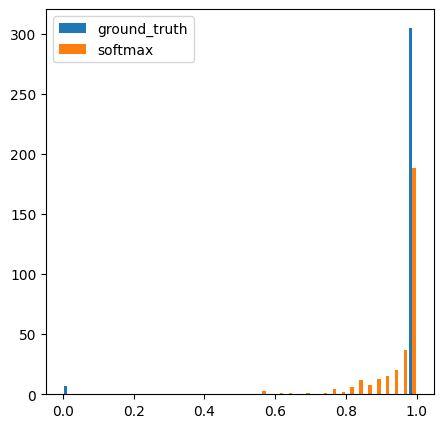

In [24]:
threshold_energy = np.percentile(normalized_energy.tolist(),60)
query_per90 = [i for i in range(len(query_ids)) if normalized_energy[i]>threshold_energy]
labels = ['ground_truth','softmax']
data=[abs(1-pair_labels[query_per90]),old_softmax[:,0].detach().numpy()[query_per90]]
plt.figure(figsize=(5, 5))
plt.hist(data,bins =40, label = labels)
plt.legend()
plt.show()

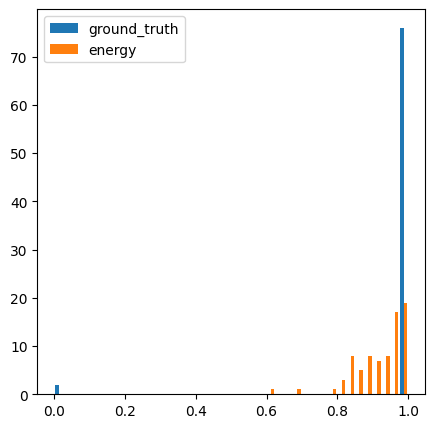

In [25]:
threshold_energy = np.percentile(old_softmax[:,0].tolist(),90)
query_per90 = [i for i in range(len(query_ids)) if old_softmax[:,0][i]>threshold_energy]
labels = ['ground_truth','energy']
data=[abs(1-pair_labels[query_per90]),normalized_energy.detach().numpy()[query_per90]]
plt.figure(figsize=(5, 5))
plt.hist(data,bins =40, label = labels)
plt.legend()
plt.show()

In [128]:
len(query_per90)

65

In [111]:
labels = softmax.argmax(dim=1)
labels = [0 if normalized_energy[i]>=0.5 else 1 for i in range(len(normalized_energy))]


In [97]:
labels.size()

torch.Size([642])

In [107]:
sum(np.abs(labels-pair_labels))

246

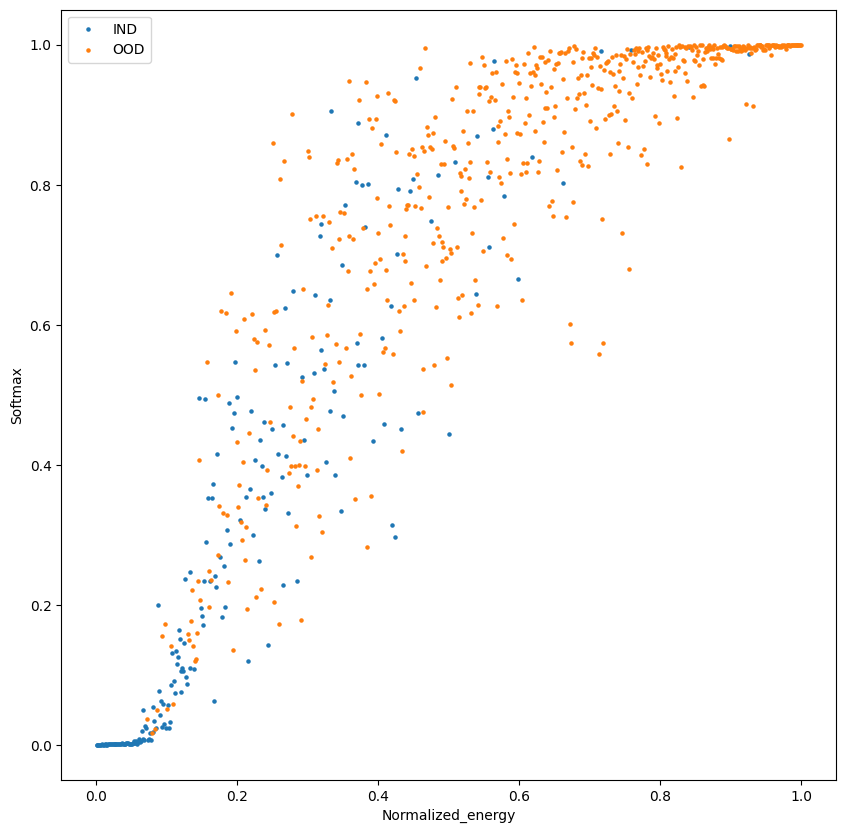

In [27]:
size = 200 
plt.figure(figsize=(10, 10))
plt.scatter(x=normalized_energy.detach().numpy()[query_ind_idx],y = old_softmax[:,0].detach().numpy()[query_ind_idx],label = "IND",s=5)
plt.scatter(x=normalized_energy.detach().numpy()[query_ood_idx],y = old_softmax[:,0].detach().numpy()[query_ood_idx],label = "OOD",s=5)
plt.xlabel("Normalized_energy")
plt.ylabel("Softmax")
plt.legend()
plt.show()

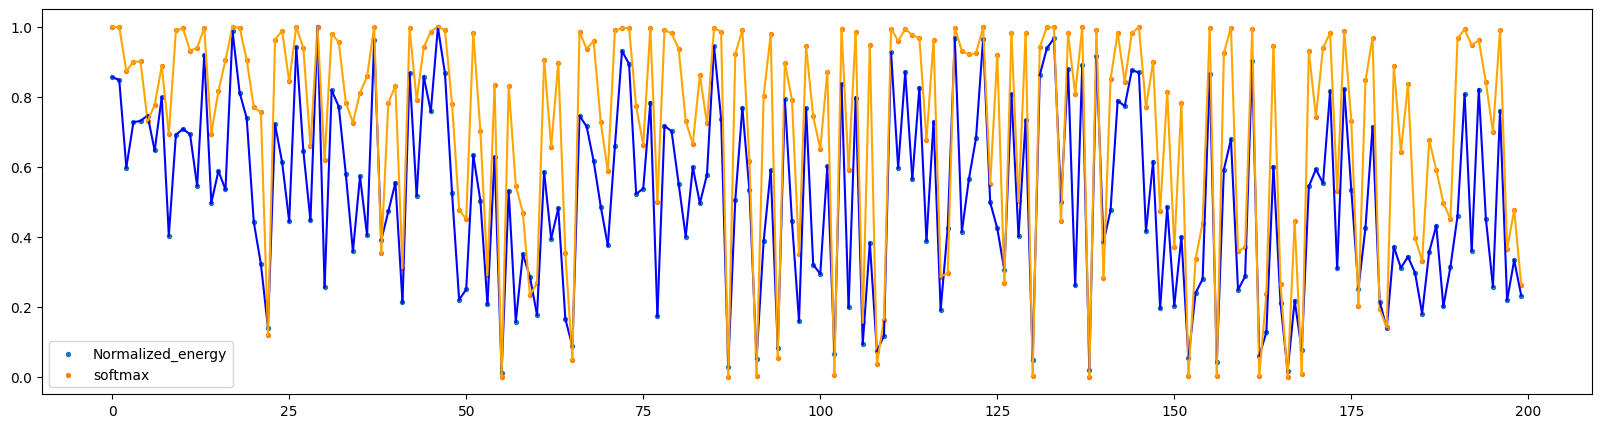

In [28]:
size = 200
plt.figure(figsize=(20, 5))
plt.scatter(x=range(len(query_ids[:size])),y = normalized_energy.detach().numpy()[:size],s=8,label="Normalized_energy")
plt.scatter(x=range(len(query_ids[:size])),y = old_softmax[:,0].detach().numpy()[:size],s=8,label= "softmax")
for i in range(len(query_ids[:size])-1):
    # plt.plot([i, i],[normalized_energy.detach().numpy()[i], softmax[:,0].detach().numpy()[i]],color='red', linestyle='--')
    plt.plot([i, i+1],[normalized_energy.detach().numpy()[i],normalized_energy.detach().numpy()[i+1]],color='blue')
    plt.plot([i, i+1],[old_softmax[:,0].detach().numpy()[i],old_softmax[:,0].detach().numpy()[i+1]],color='orange')
plt.legend()
plt.show()

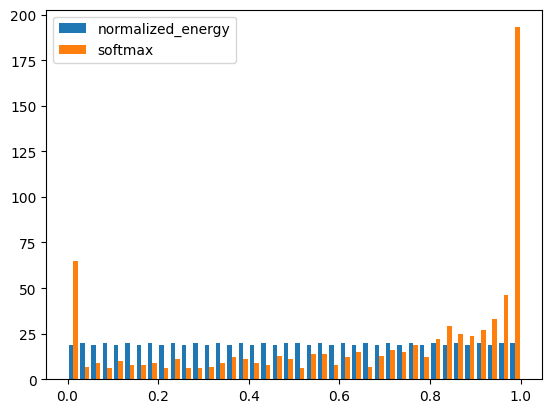

In [29]:
labels = ['normalized_energy','softmax']
data=[normalized_energy.detach().numpy(),old_softmax[:,0].detach().numpy()]
plt.hist(data,bins =40, label = labels)
plt.legend()
plt.show()

In [94]:
old_predicted_labels = predicted_labels

In [41]:
def min_max_norm(data):
    min_val = torch.min(data)
    max_val = torch.max(data)
    return (data - min_val) / (max_val - min_val)

def percentile(x,data):
    return len([data[i] for i in range(len(data)) if data[i]<=x ])/len(data)
def percentile_norm(data):
    return torch.tensor([percentile(data[i],data) for i in range(len(data))])


normalized_energy = percentile_norm(energy_train)
# softmax = torch.softmax(logits,dim=1)
alpha = 0.7


SOFTMAX

In [42]:
from scipy.special import softmax
old_softmax = torch.softmax(logits,dim=-1)
new1_softmax=old_softmax.detach().cpu().numpy()
new1_softmax[:,0] = alpha* old_softmax[:,0].detach().cpu().numpy() + (1-alpha)*normalized_energy.detach().cpu().numpy()
new1_softmax = softmax(new1_softmax,axis=-1)
predicted1_labels = new1_softmax.argmax(axis=1)

from sklearn.metrics import f1_score, precision_score, recall_score
import sklearn
fpr, tpr, thresholds = sklearn.metrics.roc_curve(pair_labels, new1_softmax[:,1], pos_label=1)
auc = sklearn.metrics.auc(fpr, tpr)
f1_macro = f1_score(pair_labels, predicted1_labels, average='macro')
f1_micro = f1_score(pair_labels, predicted1_labels, average='micro')
f1 = f1_score(pair_labels, predicted1_labels)

# this is the normal precision and recall we seen so many times
precision_true_class = precision_score(pair_labels, predicted1_labels, labels=[1], average=None)[0]
recall_true_class = recall_score(pair_labels, predicted1_labels, labels=[1], average=None)[0]
f1_true_class = f1_score(pair_labels, predicted1_labels, labels=[1], average=None)[0]

precision_false_class = precision_score(pair_labels, predicted1_labels, labels=[0], average=None)[0]
recall_false_class = recall_score(pair_labels, predicted1_labels, labels=[0], average=None)[0]
f1_false_class = f1_score(pair_labels, predicted1_labels, labels=[0], average=None)[0]

print(f"AUC:                {round(auc,6)}")
print(f"f1_macro:           {round(f1_macro,6)}")
print(f"f1_micro:           {round(f1_micro,6)}")
print(f"recall_true_class:  {round(recall_true_class,6)}")
print(f"f1_false_class:     {round(f1_false_class,6)}")
print(f"recall_false_class: {round(recall_false_class,6)}")


AUC:                0.892604
f1_macro:           0.803345
f1_micro:           0.838668
recall_true_class:  0.77512
f1_false_class:     0.886691
recall_false_class: 0.861888


AUC:                0.889802
f1_macro:           0.800668
f1_micro:           0.838668
recall_true_class:  0.751196
f1_false_class:     0.887701
recall_false_class: 0.870629

AUC:                0.748648
f1_macro:           0.681228
f1_micro:           0.694704
recall_true_class:  0.860119
f1_false_class:     0.615686
recall_false_class: 0.513072

1-softmax

In [331]:
from sklearn.metrics import f1_score, precision_score, recall_score
import sklearn
old_softmax = torch.softmax(logits,dim=-1)


new_softmax = old_softmax.detach().cpu().numpy()
new_softmax[:,0] = alpha* old_softmax[:,0].detach().cpu().numpy() + (1-alpha)*normalized_energy.detach().cpu().numpy()
new_softmax[:,1] = 1-new_softmax[:,0]/(new_softmax[:,1]+new_softmax[:,0])
new_softmax[:,0] = 1.0 - new_softmax[:,1]
predicted_labels = new_softmax.argmax(axis=1)

fpr, tpr, thresholds = sklearn.metrics.roc_curve(pair_labels, new_softmax[:,1], pos_label=1)
auc = sklearn.metrics.auc(fpr, tpr)
f1_macro = f1_score(pair_labels, predicted_labels, average='macro')
f1_micro = f1_score(pair_labels, predicted_labels, average='micro')
f1 = f1_score(pair_labels, predicted_labels)

# this is the normal precision and recall we seen so many times
precision_true_class = precision_score(pair_labels, predicted_labels, labels=[1], average=None)[0]
recall_true_class = recall_score(pair_labels, predicted_labels, labels=[1], average=None)[0]
f1_true_class = f1_score(pair_labels, predicted_labels, labels=[1], average=None)[0]

precision_false_class = precision_score(pair_labels, predicted_labels, labels=[0], average=None)[0]
recall_false_class = recall_score(pair_labels, predicted_labels, labels=[0], average=None)[0]
f1_false_class = f1_score(pair_labels, predicted_labels, labels=[0], average=None)[0]
print(f"AUC:                {round(auc,6)}")
print(f"f1_macro:           {round(f1_macro,6)}")
print(f"f1_micro:           {round(f1_micro,6)}")
print(f"recall_true_class:  {round(recall_true_class,6)}")
print(f"f1_false_class:     {round(f1_false_class,6)}")
print(f"recall_false_class: {round(recall_false_class,6)}")


AUC:                0.745672
f1_macro:           0.686498
f1_micro:           0.697819
recall_true_class:  0.848214
f1_false_class:     0.626923
recall_false_class: 0.53268


TEST APPROACH 2

In [328]:
sum(abs(predicted_labels - predicted1_labels))

0

In [91]:

softmax = torch.softmax(logits,dim=1)
predicted_labels = softmax.argmax(dim=1)
threshold = -1
predicted_labels = [0 if energy_train[i] > threshold else predicted_labels[i] for i in range(predicted_labels.size(0))]
predicted_labels = torch.tensor([x for x in predicted_labels])

In [92]:
test = []
for i in range(old_predicted_labels.size(0)):
    if (energy_train[i] > threshold and old_predicted_labels[i]==1):
        test.append(old_predicted_labels[i])
print(len(test))

NameError: name 'old_predicted_labels' is not defined

In [106]:
print(predicted_labels-old_predicted_labels)

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        -1,  0,  0,  0,  0,  0,  0,  0, 

In [226]:

f1_macro = f1_score(pair_labels, predicted_labels, average='macro')
f1_micro = f1_score(pair_labels, predicted_labels, average='micro')
f1 = f1_score(pair_labels, predicted_labels)

# this is the normal precision and recall we seen so many times
precision_true_class = precision_score(pair_labels, predicted_labels, labels=[1], average=None)[0]
recall_true_class = recall_score(pair_labels, predicted_labels, labels=[1], average=None)[0]
f1_true_class = f1_score(pair_labels, predicted_labels, labels=[1], average=None)[0]

precision_false_class = precision_score(pair_labels, predicted_labels, labels=[0], average=None)[0]
recall_false_class = recall_score(pair_labels, predicted_labels, labels=[0], average=None)[0]
f1_false_class = f1_score(pair_labels, predicted_labels, labels=[0], average=None)[0]

f1_macro:0.774153396452175
f1_micro:0.7780898876404494
recall_true_class:0.8709677419354839
f1_false_class:0.7443365695792881
recall_false_class:0.6764705882352942

In [227]:

print(f"f1_macro:{f1_macro}")
print(f"f1_micro:{f1_micro}")
print(f"recall_true_class:{recall_true_class}")
print(f"f1_false_class:{f1_false_class}")
print(f"recall_false_class:{recall_false_class}")

f1_macro:0.774153396452175
f1_micro:0.7780898876404494
recall_true_class:0.8709677419354839
f1_false_class:0.7443365695792881
recall_false_class:0.6764705882352942


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde

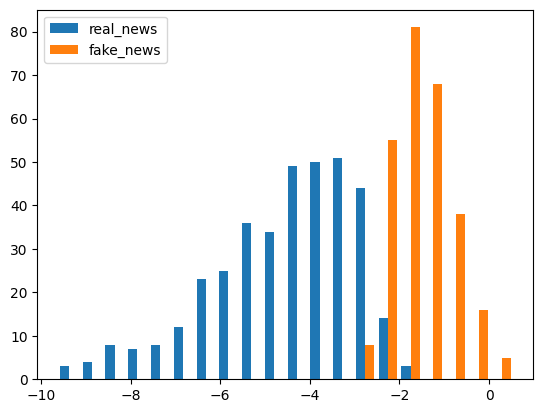

In [142]:
labels = ['real_news','fake_news']
data=[energy_train.detach().numpy()[query_real_idx],energy_train.detach().numpy()[query_fake_idx]]
plt.hist(data,bins =20, label = labels)
plt.legend()
plt.show()

In [33]:
def plot_kde(data, x_label, title):
  kde_obj = kde.gaussian_kde(data)

  x_grid = np.linspace(data.min(), data.max(), 400)
  density = kde_obj(x_grid)

  plt.plot(x_grid, density, label='KDE')

  plt.xlabel(x_label)
  plt.ylabel('Density')
  plt.title(title)
  plt.grid(True)
  plt.show()

/var/folders/s1/ttyz18893hn76tz48dhzp9cr0000gn/T/ipykernel_74024/198493470.py:1: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kde_obj_ind = kde.gaussian_kde(energy_train.detach().numpy()[query_ind_idx])
/var/folders/s1/ttyz18893hn76tz48dhzp9cr0000gn/T/ipykernel_74024/198493470.py:6: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kde_obj_ood = kde.gaussian_kde(energy_train.detach().numpy()[query_ood_idx])


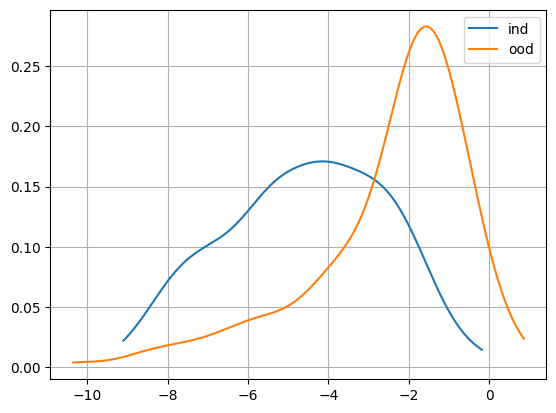

In [32]:

kde_obj_ind = kde.gaussian_kde(energy_train.detach().numpy()[query_ind_idx])

x_ind = np.linspace(energy_train.detach().numpy()[query_ind_idx].min(), energy_train.detach().numpy()[query_ind_idx].max(), 400)
density_ind = kde_obj_ind(x_ind)
plt.plot(x_ind, density_ind, label='ind')
kde_obj_ood = kde.gaussian_kde(energy_train.detach().numpy()[query_ood_idx])

x_ood = np.linspace(energy_train.detach().numpy()[query_ood_idx].min(), energy_train.detach().numpy()[query_ood_idx].max(), 400)

density_ood = kde_obj_ood(x_ood)

plt.plot(x_ood, density_ood, label='ood')

# Set labels and title.
# plt.xlabel(x_label)
# plt.ylabel('Density')
# plt.title(title)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# predictions = match_model.predict(left_contents[:1], evd_docs_contents[:1], **additional_paramters)
phi,output,avg,query_repr,doc_out_ggnn,query_repr1,avg1 = match_model.predict(left_contents, evd_docs_contents, **additional_paramters)


In [ ]:
type(output)

torch.Tensor

Test Percentile 

TEST LABEL PROBAGATION

In [ ]:
outputs = 

In [39]:
adj_matrix = outputs.matmul(outputs.T)

In [41]:
threshold = 0.5
adj_matrix[0][0]

tensor(16.3488, grad_fn=<SelectBackward0>)